# Energy measuring procedure

In [37]:
# %matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
from IPython.display import Image
from IPython.core.display import HTML
from hctf import HCTF
import os

ModuleNotFoundError: No module named 'bmcs_utils.hctf'

## Mathematical condition:

- 2 segments p-p+r, q-q+s are intersecting if the cross product of ( p,p+r,q+s) is different than (p,p+r,q),
and the cross product of (q,q+s,p) and (q,q+s,p+r) is also different. We see that we need to generate 6 different vectors
for checking if two segments are intersecting

In [3]:
Image(url="https://i.stack.imgur.com/vD4g5.png")

## Recreation of a fictitious loop:

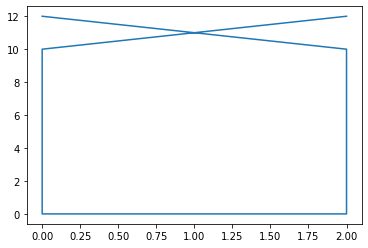

In [7]:
# Simulating hysteretic loop

x1=np.linspace(0.00,2.,10)
x2=np.linspace(2.,2.,20)
x3=np.linspace(2.,0.,15)
x4=np.linspace(0.00,0.00,30)
x5=np.linspace(0.00,2.,20)
x_descending=np.concatenate((x1,x2,x3))[:,np.newaxis] # associated to x coordinates of descending branch
x_ascending=np.concatenate((x4,x5))[:,np.newaxis] # associated to x coordinates of ascending branch

y1=np.linspace(12.,10.,10)
y2=np.linspace(10.,0.,20)
y3=np.linspace(0.,0.,15)
y4=np.linspace(0.,10.,30)
y5=np.linspace(10.,12.,20)
y_descending=np.concatenate((y1,y2,y3))[:,np.newaxis]
y_ascending=np.concatenate((y4,y5))[:,np.newaxis]

force_array = np.concatenate((y1,y2,y3,y4,y5))
disp_array = np.concatenate((x1,x2,x3,x4,x5))

force_max_indices=[0,len(force_array)-1]
force_min_indices=[35]

plt.plot(disp_array,force_array)

We select each individual segment of the descending branch, starting from the left side, and apply the described mathematical
condition with each of the segments of the ascending branch. Once that the intersection is found, break the loop.
Inefficient.

In general, the actual intersection point does not exist, so we have to calculate it

In [30]:
def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x.reshape(1,), y.reshape(1,)




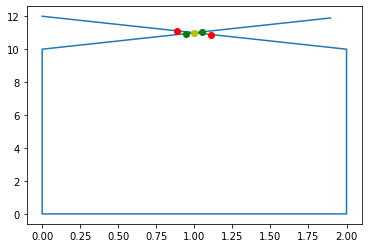

[0, array(21.)]


In [33]:
x_descending = []
x_ascending = []
y_descending = []
y_ascending = []
inter_descending = []
inter_ascending = []
dissipated_energy = [0]

for i in range(len(force_max_indices) - 1):
    x_descending.append(disp_array[force_max_indices[i]:force_min_indices[i]].tolist())
    x_ascending.append(disp_array[force_min_indices[i]:force_max_indices[i + 1]].tolist())
    y_descending.append(force_array[force_max_indices[i]:force_min_indices[i]].tolist())
    y_ascending.append(force_array[force_min_indices[i]:force_max_indices[i + 1]].tolist())

# Looping over each loading-unloading cycle
for k in range(len(force_max_indices) - 1):
    
    intersect = 0
    
    for i in range(len(x_descending[k]) - 1):  # index i for i-th segment of descending branch
        
        vector1 = np.array([
            np.array(x_descending[k][i + 1]) - np.array(x_descending[k][i]), np.array(y_descending[k][i + 1]) - np.array(y_descending[k][i])]).reshape(-1)
        
        # 1st of the 6 needed vectors for mathematical condition, p-p+r from example
        
        for j in range(1, len(x_ascending[k])):
            vector2 = np.array([np.array(x_ascending[k][len(x_ascending[k]) - j]) - np.array(np.array(x_descending[k][i + 1])),
                                np.array(y_ascending[k][len(y_ascending[k]) - j]) - np.array(y_descending[k][i + 1])]).reshape(-1)
            vector3 = np.array([np.array(x_ascending[k][len(x_ascending[k]) - j - 1]) - np.array(x_descending[k][i + 1]),
                                np.array(y_ascending[k][len(y_ascending[k]) - j - 1]) - np.array(y_descending[k][i + 1])]).reshape(-1)
            vector4 = np.array(
                [np.array(x_ascending[k][len(x_ascending[k]) - j - 1]) - np.array(x_ascending[k][len(x_ascending[k]) - j]),
                 np.array(y_ascending[k][len(y_ascending[k]) - j - 1]) - np.array(y_ascending[k][len(y_ascending[k]) - j])]).reshape(-1)
            
            # q-q+s vector from example
            
            vector5 = np.array([np.array(x_descending[k][i]) - np.array(x_ascending[k][len(x_ascending[k]) - j - 1]),
                                np.array(y_descending[k][i]) - np.array(y_ascending[k][len(y_ascending[k]) - j - 1])]).reshape(-1)
            vector6 = np.array([np.array(x_descending[k][i + 1]) - np.array(x_ascending[k][len(x_ascending[k]) - j - 1]),
                                np.array(y_descending[k][i + 1]) - np.array(y_ascending[k][len(y_ascending[k]) - j - 1])]).reshape(-1)
            d1 = np.cross(vector1, vector2)
            d2 = np.cross(vector1, vector3)
            d3 = np.cross(vector4, vector5)
            d4 = np.cross(vector4, vector6)
            
            # Mathematical condition
            
            if (np.sign(d1) != np.sign(d2)) & (np.sign(d3) != np.sign(d4)):
                intersect = 1
                break
                
        if intersect == 1:
            break

    if intersect == 1:
        
        # Intersection between A,B - C,D
        
        A = np.array([x_descending[k][i], y_descending[k][i]])
        B = np.array([x_descending[k][i + 1], y_descending[k][i + 1]])
        C = np.array([x_ascending[k][len(x_ascending[k]) - j], y_ascending[k][len(x_ascending[k]) - j]])
        D = np.array([x_ascending[k][len(x_ascending[k]) - j - 1], y_ascending[k][len(x_ascending[k]) - j - 1]])
        inter_descending.append([A, B])
        inter_ascending.append([C, D])
        
        # x and y coordinates of the intersection
        inter_x, inter_y = line_intersection((A, B), (C, D))

        # Plotting loop
        plt.figure()
        plt.plot(np.concatenate((x_descending[k], x_ascending[k])), np.concatenate((y_descending[k], y_ascending[k])))
        # # Plotting intersection segment from descending branch
        plt.plot(x_descending[k][i], y_descending[k][i], 'ro')
        plt.plot(x_descending[k][i + 1], y_descending[k][i + 1], 'ro')
        # # Plotting intersection and intersection segment from ascending branch
        plt.plot(inter_x, inter_y, 'yo')
        plt.plot(x_ascending[k][len(x_ascending[k]) - j], y_ascending[k][len(x_ascending[k]) - j], 'go')
        plt.plot(x_ascending[k][len(x_ascending[k]) - j - 1], y_ascending[k][len(x_ascending[k]) - j - 1], 'go')
        plt.show()
        #
        # Creating array containing just the loop

        x = np.concatenate(
            ([inter_x, np.array(x_descending[k][i + 1:]), np.array(x_ascending[k][:(len(x_ascending[k]) - j)]),
             inter_x]),axis=0)
        y = np.concatenate(
            ([inter_y, np.array(y_descending[k][i + 1:]), np.array(y_ascending[k][:(len(x_ascending[k]) - j )]),
             inter_y]),axis=0)

        int = scipy.integrate.cumtrapz(y.reshape(-1), x.reshape(-1))
        dissipated_energy.append(np.array(int[-1] + dissipated_energy[-1]))
        print(dissipated_energy)

## Implementation in real example

In [8]:
hcft = HCFT()

home_dir = os.path.expanduser('~')

path = os.path.join(
    home_dir, 'Data Processing/' + 'fatigue_LS4/' + 'Smax_0.85/' + '05/' )

# Load force array and generate max and min of it
force_array = np.array(np.loadtxt(os.path.join(path, 'B-L60-05-430_force.txt')))

force_max_indices, force_min_indices = hcft.get_array_max_and_min_indices(force_array.flatten())

# Optional (if you want max and min indicies in one array)
force_max_min_indices = np.concatenate((force_min_indices, force_max_indices))
force_max_min_indices.sort()

# Cut the fake cycles because of noise (important!)
force_max_indices_cut, force_min_indices_cut = np.array(hcft.cut_indices_of_defined_range(force_array.flatten(),
                                                                                 force_max_indices,
                                                                                 force_min_indices,
                                                                                 12))

# Load displacement array and get the values corresponding to max and min of the force
disp_array = np.array(np.loadtxt(os.path.join(path, 'B-L60-05-430_opening.txt')))
array_rest_maxima = disp_array.flatten()[force_max_indices_cut]
array_rest_minima = disp_array.flatten()[force_min_indices_cut]

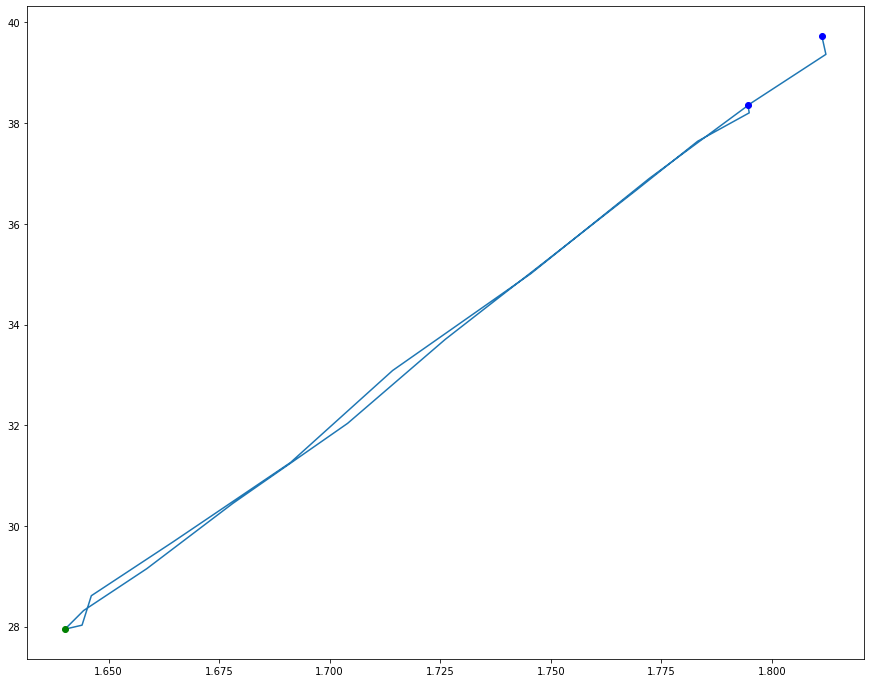

In [12]:
inter_descending,inter_ascending = find_intersection_segment(force_array, disp_array, force_max_indices, force_min_indices)